# The KdV equation

In this notebook, we consider the one-dimensional forced Korteweg–de Vries (KdV) equation for waves on shallow water. It is given by
\begin{equation}
u_t + \eta u u_x + \gamma^2 u_{xxx} = g(x,t),
\end{equation}
where $\eta, \gamma \in \mathbb{R}$. If $g(x,t) = 0$, we have the standard unforced KdV equation.

For the standard KdV equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \int_\mathbb{R} \left(-\frac{\eta}{6} u^3 + \frac{\gamma^2}{2}u_x^2 \right)\, dx
\end{align*}
$$
is conserved, i.e. constant over time.

In this notebook I will use a neural operator network, in an attempt to learn the transformation from initial conditions (at $t=0$) to solutions at a later timepoints, $t>0$.

I will also enfore hard constraints on the network, to make it preserve the Hamiltonian.

# Generate test data

For the initial conditions, I will use a system with two waves.
As this does not have an analytic solution, I will use the midpoint method to generate approximations, which will be used in the training of the NN.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

In [4]:
import jax
import jax.numpy as jnp
import equinox as eqx
from jax import random
key = random.key(42)
np.random.seed(42)

In [18]:
def sech(x): return 1/jnp.cosh(x)

In [5]:
def initial_condition_kdv(x=np.linspace(0,20.-.2,100), eta=6.):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    k1, k2 = np.random.uniform(0.5, 2, 2)
    d1, d2 = np.random.uniform(0, 1, 2)
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

In [95]:
#jax version
def initial_condition_kdv(key, x=jnp.linspace(0,20,100), eta=6.):
    key, *subkeys = random.split(key, 3)
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    c1, c2 = random.uniform(subkeys[0], minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(subkeys[1], minval=0, maxval=1, shape=(2,))
    
    u0 = c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    #u0 = jnp.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0, key

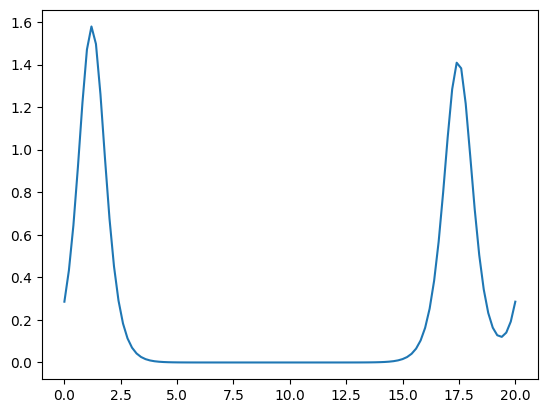

In [102]:
x=jnp.linspace(0,20,100)
def grid(P=20, M=100):
    dx = P/M
    x = jnp.linspace(0, P, M+1) # jnp.linspace(0, P-dx, M)?
    return x, dx
x, dx = grid()
y, key = initial_condition_kdv(key, x=x)

plt.plot(x, y)

In [103]:
def difference_matrices(P=20, M=100):
    dx = P/M
    #e = jnp.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    #D1 = .5/dx*spdiags([e,-e,e,-e], jnp.array([-M+1,-1,1,M-1]), M, M).toarray()
    first_col = jnp.zeros(M)
    first_col = first_col.at[1].set(-1)
    first_col = first_col.at[-1].set(1)
    D1 = 0.5/dx*jax.scipy.linalg.toeplitz(first_col, -first_col)
    # 2nd order central difference matrix:
    first_col = jnp.zeros(M)
    first_col = first_col.at[0].set(-2)
    first_col = first_col.at[1].set(1)
    first_col = first_col.at[-1].set(1)
    #D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], jnp.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    D2 = 1/dx**2*jax.scipy.linalg.toeplitz(first_col)
    
    # Foward difference matrix
    #Dp = .5/dx*spdiags([e,-e,e,-e], jnp.array([-M+1,-1,1,M-1]), M, M).toarray()
    #first_col = jnp.zeros(M)
    
    #Dp = 0.5/dx*jax.scipy.linalg.toeplitz(first_col)
    return D1, D2#, Dp

In [106]:
# PARAMETERS
P = 20
M = 100 # increase or decrease M to see how the approximation gets better/worse
eta = 6.
gamma = 1.
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

t_max = 1
N = 100
t, dt = grid(t_max, N)

In [105]:
# g = lambda x, t: 3*np.sin(2*np.pi*t)
#g = lambda x, t: np.sin(2*np.pi/P*x)*np.ones_like(t)
#g = lambda x, t: 0*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
#f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) #+ g(x, t)
#Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

def f(u, D1, D2, eta, gamma):
    return -jnp.matmul(D1, .5*eta*u**2 + gamma**2*jnp.matmul(D2,u))

def Df(u, D1, D2, eta, gamma):
    return -jnp.matmul(D1, eta*jnp.diag(u) + gamma**2*D2)

In [82]:
from jax import grad

def midpoint_method(u,un,t,f,Df,dt,M,tol,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = jnp.eye(M)
    
    def F(u_hat):
        return 1/dt*(u_hat-u) - f((u+u_hat)*0.5, t+0.5*dt)
    
    def J(u_hat):
        return 1/dt*I - 0.5*Df((u+u_hat)*0.5)
    
    #F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)*0.5, t+0.5*dt)
    #J = lambda u_hat: 1/dt*I - 0.5*Df((u+u_hat)/2)
    err = jnp.linalg.norm(F(un))
    it = 0
    while err > tol and it < max_iter:
        un = un - jnp.linalg.solve(J(un), F(un))
        err = jnp.linalg.norm(F(un))
        it += 1

    return un

In [83]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

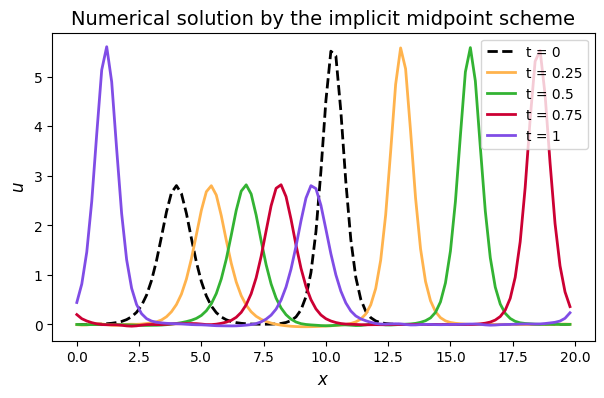

In [84]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()

In [85]:

# The discrete Hamiltonian
#H = lambda u: dx*np.sum(-1/6*eta*u**3 + (.5*gamma**2*(np.matmul(Dp,u.T))**2).T, axis=1)

def H(u, dx, eta, gamma, Dp):
    return dx*jnp.sum(-1/6*eta*u**3 + (.5*gamma**2*(jnp.matmul(Dp,u.T))**2).T, axis=1)

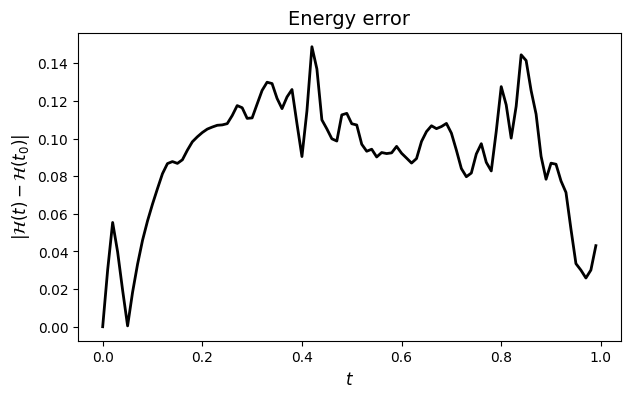

In [86]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(t, np.abs(H(u)-H(u)[0]), 'k', linewidth=lw)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$|\mathcal{H}(t) - \mathcal{H}(t_0)|$', fontsize=12)
plt.title('Energy error', fontsize=14)
plt.show()

## Generating the samples

In [95]:
num_samples = 2048
M = 100
P = 20
D1, D2 = difference_matrices(P,M)

x, dx = grid(P, M)

t_max = 1
N = 100
t, dt = grid(t_max, N)

X = np.zeros((num_samples, M))
Y = np.zeros((num_samples, M))

#g = lambda x, t: 0*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) #+ g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

for j in range(num_samples):
    u0 = initial_condition_kdv(x)
    X[j,:] = u0
    
    un = u0
    for i, t_step in enumerate(t[:-1]):
        un = midpoint_method(un, un, t[i], f, Df, dt, M, 1e-12, 5)
    
    Y[j,:] = un

In [97]:
np.savez('kdv_data.npz', X=X, Y=Y)